# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"

## Estudiantes: 

- Hernández Mancipe Daniel Felipe
- Panadero de las Heras José Luis 
- Thoux Durán Alejandro Napoleón 
- Velastegui Izurieta Homero Javier 

# **Introducción**

En el presente proyecto se utilizó una instancia **g4dn.2xlarge de** AWS que está diseñada para tareas de aprendizaje automático, inferencia y procesamiento gráfico moderado. Cuenta con 8 vCPUs basadas en procesadores Intel Xeon escalables, 32 GB de memoria RAM y una GPU NVIDIA T4 con 16 GB de memoria de video, lo que permite acelerar modelos de deep learning, análisis de imágenes, renderizado y aplicaciones con CUDA. Además, incluye NVMe local de alto rendimiento (aprox. 225 GB) para acceso rápido a datos temporales, hasta 25 Gbps de ancho de banda de red y soporte para EBS para almacenamiento adicional. Está optimizada para entrenamiento de modelos pequeños o medianos, inferencia en producción, desarrollo de modelos y aplicaciones de visualización 3D.

Dado que se utilizó una instancia remota, algunas etapas del entrenamiento se ejecutaron mediante scripts en Python gestionados con tmux, en lugar de seguir íntegramente la estructura de ejecución típica en Jupyter Notebook. Esto se debe a que Jupyter Lab, aunque útil para exploración, prototipado y visualización, puede interrumpir el entrenamiento si la sesión web se cierra o si existe inestabilidad en la conexión. En cambio, el uso de scripts junto con tmux permite mantener el proceso activo en segundo plano de forma persistente, incluso si el usuario cierra la terminal o el navegador, garantizando continuidad en entrenamientos prolongados.

Por ello, el proyecto se desarrolló de forma híbrida: se realizaron fases de análisis exploratorio, pruebas y visualizaciones en Jupyter Lab, mientras que los entrenamientos definitivos y la ejecución de modelos se llevaron a cabo mediante scripts independientes en la instancia, asegurando estabilidad y reportando los resultados en este documento.


## **a. Descripción del Dataset**

El dataset asignado al Grupo 15 fue **Lemon Quality Dataset**,  este es un conjunto de imágenes orientado a la **clasificación automática de la calidad de limones** mediante técnicas de Visión por Computador y Aprendizaje Profundo. El dataset contiene imágenes capturadas bajo condiciones de iluminación natural y fondos uniformes, lo que facilita su uso en modelos basados en redes neuronales convolucionales (CNNs). Las imágenes muestran limones en diferentes estados de calidad, principalmente **limones en buen estado** y **limones deteriorados**, aunque la versión empleada en este proyecto incluye además una categoría adicional que representa **imágenes sin limón**.

## **b. Estructura y Organización del Dataset**

En la versión utilizada en este proyecto, el dataset está organizado en tres carpetas, cada una correspondiente a una clase de clasificación:

| Carpeta             | Clase               | Descripción                                                                               |
|--------------------|--------------------|-------------------------------------------------------------------------------------------|
| `good_quality`      | Limón en buen estado | Imágenes de limones con apariencia fresca y sin signos visibles de daño o deterioro.      |
| `bad_quality`       | Limón en mal estado  | Imágenes de limones con señales de deterioro, manchas, podredumbre o deformaciones.       |
| `empty_background`  | Fondo vacío         | Imágenes sin limón útil en la escena; actúa como clase de control negativo.               |

Esta estructura permite formular una **tarea de clasificación multiclase**, donde el modelo debe aprender a distinguir visualmente entre limones buenos, limones en mal estado y ausencia de limón.

Aunque el número de imágenes puede variar según la versión descargada, en el presente proyecto la distribución del conjunto es la siguiente:

| Clase               | Nº aproximado de imágenes | Propósito en la clasificación |
|--------------------|--------------------------|------------------------------|
| `good_quality`       | 1125                    | Representa producto apto para comercialización. |
| `bad_quality`        | 952                     | Permite identificar fruta dañada o no apta.      |
| `empty_background`   | 452   | Ayuda al modelo a descartar imágenes irrelevantes. |

## **c. Objetivo del Dataset en el Contexto del Proyecto**

El objetivo central del dataset es **servir como base para el entrenamiento, validación y evaluación de modelos de clasificación de imágenes** que permitan determinar automáticamente el estado de calidad de un limón. Este problema es una tarea de **clasificación visual aplicada**, donde las características que diferencian categorías son sutiles (manchas, textura de la cáscara, coloración, etc.).

En este proyecto, el dataset se empleará para comparar dos estrategias de aprendizaje profundo:

1. **Entrenamiento desde cero (from scratch):**  
   Se diseña y entrenará una CNN personalizada, aplicando técnicas de regularización, ajuste de hiperparámetros y data augmentation para optimizar el rendimiento.

2. **Transfer Learning con redes preentrenadas en ImageNet:**  
   Se utilizara arquitecturas profundas como **VGG, ResNet, MobileNet o Inception**, realizando ajuste fino (fine-tuning) para adaptar la red a la tarea específica de clasificación de limones.


## **d. Importar las librerías necesarias**

Para facilitar la reproducción de la práctica, en la raíz del proyecto se ha incluido el fichero requirements.txt, el cual contiene todas las dependencias necesarias. La instalación puede realizarse desde una terminal ubicada en la raíz del proyecto mediante el siguiente comando:

```bash
pip install -r requirements.txt
```

En la sección siguiente se procederá a importar tanto las librerías requeridas como los módulos correspondientes a las clases personalizadas desarrolladas para este proyecto.

**Librerías y Dependencias**


In [2]:
from importlib import reload

**Clases Personalizadas**

In [3]:
import modulos.lemon_dataset as lemon_dataset_module
import modulos.lemon_genloader as lemon_genloader_module
import modulos.lemon_tfloader as lemon_tfloader_module
import modulos.lemon_cnn_model as lemon_cnn_model_module
reload(lemon_dataset_module)
reload(lemon_genloader_module)
reload(lemon_tfloader_module)
reload(lemon_cnn_model_module)

from modulos.lemon_dataset import LemonDataset
from modulos.lemon_genloader import LemonGenLoader
from modulos.lemon_tfloader import LemonTFLoader
from modulos.lemon_cnn_model import LemonCNNBuilder

lemon_dataset=LemonDataset()


---

# **Desarrollo**

El desarrollo del proyecto se realizó aplicando el paradigma de programación orientada a objetos. Para ello, se creó un directorio denominado modulos/, el cual contiene las clases que encapsulan la lógica necesaria para la carga de datos, el preprocesamiento, la construcción de modelos y el entrenamiento.
A lo largo de este informe, en cada sección se muestran únicamente las llamadas a los métodos correspondientes de dichas clases, con el fin de mantener el flujo del notebook claro y enfocado en el proceso experimental.

Adicionalmente, al final del documento se incluirá el código completo de las clases desarrolladas, con el propósito de proporcionar una visión integral y transparente de la solución implementada. 

## **1. Carga de datos desde la plataforma Kaggle**

En primer lugar se genera un API de Kaggle personal, para ello:
1. Registrarse en  https://www.kaggle.com
2. Ir a 'Account tab' del perfil y seleccionar 'Create API Token', se descargará un `fichero kaggle.json`
3. Guardar el fichero kaggle.json en el directorio `~/.config/kaggle/kaggle.json` de la instancia en la que se ejecutará el entrenamiento.

Una vez colocado el token de acceso de Kaggle, es necesario instalar en la instancia la API, para ello en la terminal de Linux ejecutar:

```bash
pip install kaggle
```

Se puede verificar la instalación con el comando `kaggle datasets list`, si todo está configurado de manera correcta se obtendrá el listado de datasets disponibles. En el caso de que existan problemas, se debe verificar la ruta del archivo kaggle.json. Una vez verificado el acceso se procede a obtener el dataset, para ello se debe ejecutar en la terminal de Linux dentro del directorio del proyecto:

```bash
kaggle datasets download -d yusufemir/lemon-quality-dataset
unzip lemon-quality-dataset.zip
rm lemon-quality-dataset.zip
```

Al finalizar se debe tener un directorio con el dataset esperado con una estructura similar a la siguiente:

```bash
lemon_dataset/
│
├── bad_quality
├── empty_background
└── good_quality
```

Podemos validar la carga del dataset con el siguiente comando:


In [4]:
!ls lemon_dataset

bad_quality  empty_background  good_quality


## **2. Inspección del Dataset**

Para realizar una primera exploración del conjunto de datos, se emplearon los métodos provistos en la clase `LemonDataset`.  
Estos permiten obtener una visión general sobre la distribución, variabilidad y características de las imágenes:

- **`class_counter()`**: calcula cuántas imágenes hay por clase, ayudando a identificar posibles desbalances.
- **`show_grid_per_class(n)`**: muestra `n` ejemplos por clase, facilitando la inspección visual.
- **`check_image_shapes()`**: verifica las dimensiones de las imágenes, útil para determinar si es necesario redimensionar antes del entrenamiento.

A continuación, se presentan los resultados de esta inspección.


,Clase,Cantidad
0,bad,951
1,empty,452
2,good,1125


,"Dimensiones (H,W,C)",Cantidad
0,"(300, 300, 3)",2526
1,"(292, 300, 3)",1
2,"(300, 296, 3)",1


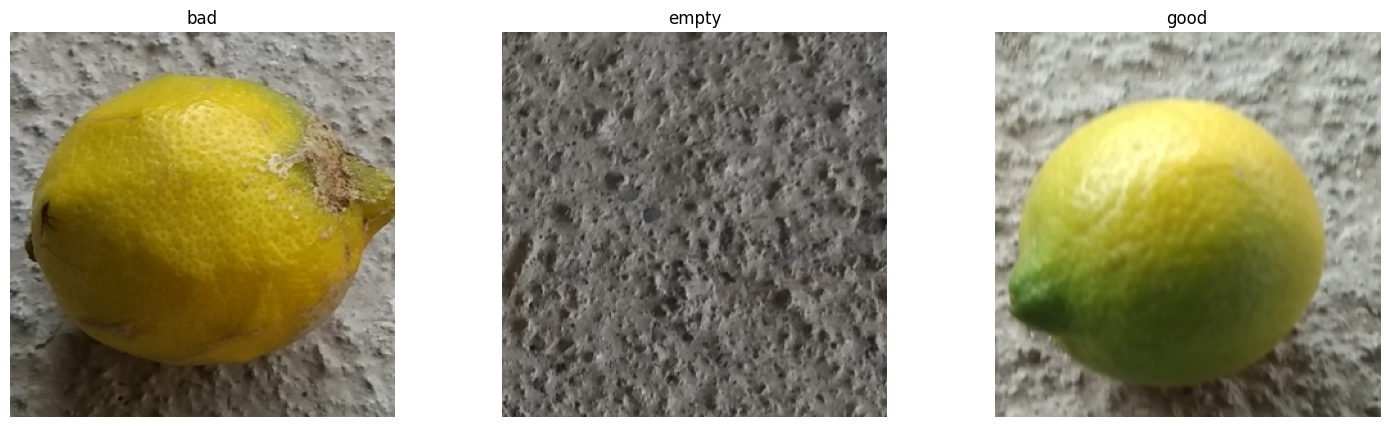

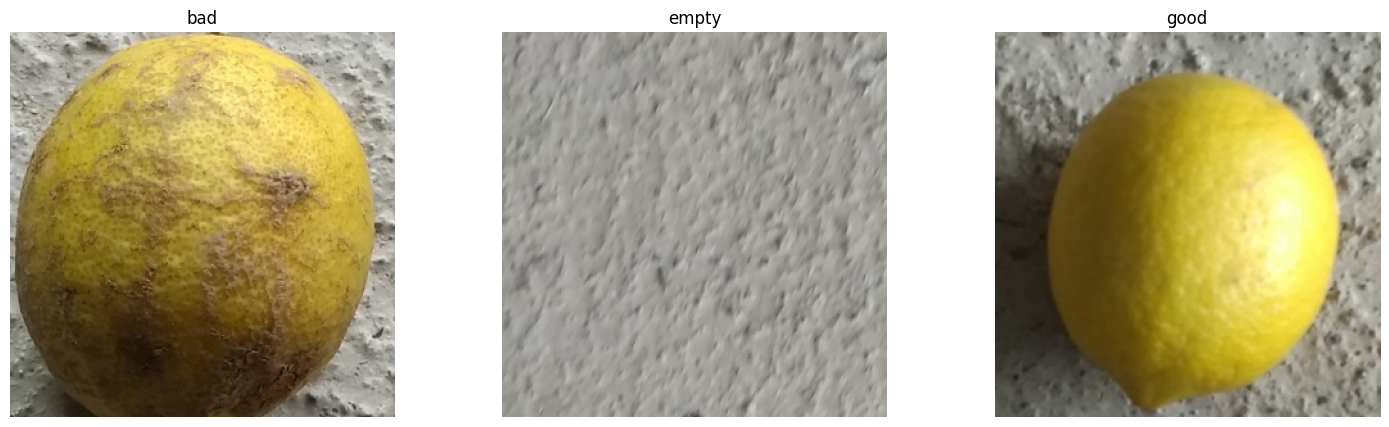

In [10]:
lemon_dataset.class_counter()
lemon_dataset.show_grid_per_class(2)
lemon_dataset.check_image_shapes()

El conjunto de datos utilizado en este proyecto fue obtenido de la plataforma Kaggle y está compuesto por imágenes de limones categorizadas en tres clases: **good_quality** (limones en buen estado), **bad_quality** (limones deteriorados) y **empty_background** (imágenes donde no aparece el fruto, utilizadas como distractores).  
El propósito de esta inspección es analizar la distribución de las clases, observar las características visuales de las imágenes y detectar posibles factores que puedan influir en el rendimiento del modelo durante el proceso de aprendizaje. Entre estos factores se consideran variaciones de iluminación, textura, enfoque, orientación y condiciones de captura en general.

### 2.1. Distribución de imágenes por clase

La siguiente tabla muestra la cantidad de muestras disponibles por categoría:

| Clase | Cantidad |
|------|---------|
| bad_quality | 951 |
| empty_background | 452 |
| good_quality | 1125 |

Se aprecia una distribución moderadamente desbalanceada entre clases, destacando que la categoría *empty_background* contiene un número menor de imágenes. Este desbalanceo podría influir en la capacidad del modelo para aprender representaciones adecuadas de dicha clase, por lo que será considerado durante el entrenamiento mediante el uso de técnicas de *data augmentation* y regularización para evitar sesgos hacia las clases mayoritarias.

### 2.2. Inspección visual de las imágenes

Con el fin de explorar la variabilidad intra-clase, se visualizaron múltiples imágenes pertenecientes a cada categoría. En el presente informe se incluyen únicamente **dos imágenes representativas por clase**, aunque durante la fase de análisis se revisaron diversas muestras adicionales para detectar patrones consistentes en textura, color, forma y condiciones de iluminación.

Las observaciones principales fueron las siguientes:

- Las imágenes de la clase **good_quality** presentan limones con color uniforme, textura regular y forma bien definida.
- Las imágenes pertenecientes a la clase **bad_quality** incluyen limones con manchas oscuras, zonas deterioradas, irregularidades en la superficie y variaciones de tono, lo que proporciona señales visuales útiles para la clasificación.
- Las imágenes de la clase **empty_background** muestran superficies rugosas y homogéneas (generalmente paredes), aunque con variaciones en luz y contraste que pueden generar cierto nivel de ambigüedad si el objeto aparece desenfocado o con bajo contraste respecto al fondo.

### 2.3. Tamaño y consistencia de las imágenes

El análisis de las dimensiones del conjunto de imágenes arrojó los siguientes resultados:

| Dimensiones (H,W,C) | Cantidad |
|--------------------|----------|
| (300, 300, 3)      | 2526     |
| (292, 300, 3)      | 1        |
| (300, 296, 3)      | 1        |

Se concluye que el dataset es **prácticamente uniforme** en términos de resolución, con solo dos imágenes ligeramente divergentes. No obstante, con el fin de mantener una **comparación justa** entre la estrategia de entrenamiento desde cero y los modelos basados en *transfer learning*, se decidió **redimensionar todas las imágenes a 224×224 píxeles** durante el pipeline de carga de datos. Este tamaño es el estándar utilizado en modelos pre-entrenados sobre ImageNet y contribuye a reducir el coste computacional, además de mitigar el riesgo de sobreajuste cuando se trabaja con conjuntos de datos de tamaño medio.

### 2.4. Resultados de la inspección

El dataset presenta una variabilidad visual suficiente para permitir el aprendizaje de patrones que diferencien las tres clases. Sin embargo, el desbalanceo de la clase *empty_background* y la presencia de variaciones en iluminación y textura hacen necesario aplicar estrategias de **data augmentation** y **regularización** para mejorar la capacidad de generalización del modelo. El uso de un **tamaño de entrada uniforme de 224×224 píxeles** permitirá asegurar la compatibilidad con arquitecturas pre-entrenadas y optimizar el rendimiento computacional durante las etapas de entrenamiento y evaluación.


## **3. Acondicionamiento del Conjunto de Datos**

Con el objetivo de preparar el dataset para el entrenamiento de los modelos, se desarrolló una estructura modular basada en programación orientada a objetos. Esta estructura permite gestionar el conjunto de imágenes, generar particiones de entrenamiento/validación/test con estratificación de clases y aplicar técnicas de *data augmentation* adaptadas a cada estrategia experimental.


### 3.1. Clase `LemonDataset`

La clase `LemonDataset` constituye el componente base del *pipeline* de datos y centraliza toda la lógica asociada a la carga, organización y preparación del conjunto de imágenes. Su objetivo es abstraer el acceso al *dataset* y proporcionar una representación adecuada y reutilizable de los datos a lo largo de las distintas etapas del proceso de entrenamiento y evaluación del modelo.

En esta clase se definen las rutas correspondientes a cada una de las categorías del problema de clasificación (`bad_quality`, `good_quality` y `empty_background`). A partir de esta estructura, el sistema recorre de forma sistemática los directorios y construye en memoria un *dataframe* que almacena, para cada muestra, la ruta completa de la imagen junto con su etiqueta de clase, facilitando así posteriores procesos de análisis, filtrado y particionado.

Una vez estructurados los datos, `LemonDataset` realiza una división estratificada del conjunto completo, asegurando que la proporción de cada clase se mantenga en todos los subconjuntos. Por defecto, esta partición se distribuye en un **70 % para entrenamiento**, un **15 % para validación** y un **15 % para prueba**, lo que permite un flujo de trabajo equilibrado entre aprendizaje, ajuste de hiperparámetros y evaluación final.

De manera adicional, la clase incorpora el parámetro `mode`, destinado a controlar la intensidad de las operaciones de *data augmentation* aplicadas a las imágenes. Este parámetro permite adaptar el mismo *dataset* a las diferentes estrategias de entrenamiento; con configuraciones agresivas orientadas para el entrenamiento desde cero (`modo scratch`), y transformaciones más conservadoras para escenarios de *transfer learning* o *fine tuning* en el modo `transfer`. 

| Modo | Uso previsto | Intensidad de *data augmentation* |
|------|--------------|-----------------------------------|
| `scratch` | Entrenamiento desde cero | Fuerte |
| `transfer` | *Transfer learning* / *fine tuning* | Moderada |


En función del modo seleccionado, la clase asigna de manera automática valores a los parámetros como el rango de rotación, el nivel de *zoom*, los ajustes de brillo y el contraste. En la clase se establecen estos valores con las siguientes constantes:

| Técnica | `scratch` (desde cero) | `transfer` (transfer learning) |
|--------|------------------------|--------------------------------|
| Brillo (`brightness_range`) | 0.7 – 1.3 (±30 %) | 0.9 – 1.1 (±10 %) |
| Brillo fino (`max_delta`) | ±0.15 | ±0.07 |
| Contraste (`contrast_range`) | 0.8 – 1.2 | 0.9 – 1.1 |
| Zoom global (`zoom_range`) | 0.75 – 1.0 | 0.07 (factor pequeño) |
| Zoom local (`zoom_ratio`) | 0.85 – 0.95 | 0.90 – 0.98 |
| Rotaciones (`rotation_range`) | Hasta 20° | Hasta 10° |

En el escenario de entrenamiento desde cero, el modelo no dispone de representaciones previas y debe aprender desde etapas muy tempranas características de bajo y medio nivel. Por esta razón, se emplea una augmentación más intensa, incorporando variaciones amplias en brillo, contraste, rotación y *zoom*. Este enfoque incrementa la diversidad efectiva del conjunto de entrenamiento y favorece la capacidad de generalización del modelo frente a variaciones no vistas durante el aprendizaje.

En contraste, en el contexto de *transfer learning*, el modelo parte de representaciones semánticas previamente aprendidas sobre grandes volúmenes de datos. En este caso, una augmentación excesiva podría alterar o degradar dichas representaciones, afectando negativamente el proceso de *fine tuning*. Por ello, se aplican transformaciones más suaves y controladas, limitando los rangos de rotación, brillo, contraste y *zoom*, con el objetivo de adaptar el modelo al nuevo dominio sin introducir distorsiones innecesarias.


### 3.2. Cargadores de Imágenes

Para la carga y acondicionamiento del *dataset* se implementaron dos métodos complementarios, con el objetivo de evaluar tanto el rendimiento predictivo de los modelos como la eficiencia computacional del pipeline de entrada de datos. Ambos enfoques fueron analizados durante las etapas iniciales de entrenamiento de la **Estrategia 1**, y el método que presentó mejores resultados fue posteriormente seleccionado para el entrenamiento de la **Estrategia 2**.

Con este propósito, se diseñaron dos clases especializadas que extienden la funcionalidad base definida en `LemonDataset`. Cada una de ellas implementa un pipeline de carga distinto, adaptado a escenarios específicos de entrenamiento, manteniendo una separación clara entre la lógica de particionado del conjunto de datos y la generación de flujos o *datasets* para el modelo.

### a. Cargador basado en `ImageDataGenerator`: Clase `LemonGenLoader`

La clase `LemonGenLoader` extiende `LemonDataset` y se apoya en `ImageDataGenerator` de Keras para construir flujos de datos directamente compatibles con el método `model.fit()`. Este enfoque permite aplicar *data augmentation* en tiempo de entrenamiento de forma sencilla y controlada, lo que resulta útil durante las fases iniciales de desarrollo del modelo.

Las características principales de este cargador son:

- Redimensionamiento uniforme de las imágenes a **224×224** píxeles.
- Normalización automática de los valores de intensidad mediante `rescale=1/255`.
- Aplicación de *data augmentation* exclusivamente sobre el conjunto de entrenamiento.
- Uso de conjuntos de validación y test sin augmentación y sin mezcla (`shuffle=False`), con el fin de preservar la consistencia y comparabilidad de las métricas de evaluación.

Las transformaciones aplicadas en este método incluyen el reescalado de intensidades, rotaciones aleatorias, variaciones de brillo, *zoom* aleatorio y volteo horizontal. Este conjunto de transformaciones facilita la inspección visual y el ajuste intuitivo de los parámetros de augmentación, permitiendo analizar cómo la variabilidad inducida afecta la capacidad del modelo para generalizar.

La división del dataset en los conjuntos de entrenamiento, test y validación con este cargador se puede realizar utilizando el siguiente código:

In [21]:
lemon_genloader=LemonGenLoader()
lemon_genloader._create_splits()
train_gen, val_gen, test_gen=lemon_genloader.get_generators()

Found 316 validated image filenames belonging to 3 classes.
Found 1453 validated image filenames belonging to 3 classes.
Found 379 validated image filenames belonging to 3 classes.
Found 380 validated image filenames belonging to 3 classes.


### b. Cargador basado en `tf.data`: Clase `LemonTFLoader`

El segundo pipeline implementado se basa en la API `tf.data`, la cual permite construir pipelines de datos optimizados para el uso eficiente de CPU y GPU. Este enfoque es adecuado para escenarios donde se trabaja con arquitecturas profundas y grandes volúmenes de datos.

Este pipeline realiza de forma estructurada las siguientes operaciones:

1. Lectura de rutas de imagen a partir de listas en formato numpy.
2. Decodificación de las imágenes y normalización en formato tensor.
3. Redimensionamiento uniforme a **224×224×3** (por defecto, es posible configurar los valores de resolución en la creación de la instancia.
4. Aplicación de *data augmentation* mediante transformaciones tensoriales, tales como volteo horizontal, ajustes de brillo y contraste, y *zoom* suave mediante `tf.image.central_crop`.
5. Agrupamiento de las muestras en lotes (`batch_size = 32`).
6. Carga anticipada de los datos mediante `prefetch`, permitiendo superponer el preprocesamiento y el entrenamiento.

Este enfoque incorpora optimizaciones propias de `tf.data`, como el uso de `map` con operaciones vectorizadas, `shuffle` para evitar sesgos derivados del orden de los datos y una gestión eficiente de los lotes. Estas características reducen la latencia durante el entrenamiento y evitan cuellos de botella en la lectura y transformación de las imágenes.

El uso de `LemonTFLoader` permite obtener los conjuntos de entrenamiento, test y validación mediante la ejecución de los siguientes comandos:

In [22]:
lemon_tfloader=LemonTFLoader()
lemon_tfloader._create_splits()
train_ds, val_ds, test_ds=lemon_tfloader.get_datasets()

display(train_ds)
display(val_ds)
display(test_ds)


Entrenamiento modo Scratch
Entrenamiento modo Scratch
Entrenamiento modo Scratch


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

## **4. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución**

### 4.1 Estrategia 1: Entrenar desde cero o from scratch

### a. Arquitectura propuesta para el modelo entrenado desde cero (from scratch)

Para la primera estrategia se diseñó una red neuronal convolucional profunda siguiendo un enfoque moderno basado en **convoluciones separables** (SeparableConv2D). A diferencia de la convolución estándar, la convolución separable descompone la operación en una convolución *depthwise* (por canal) seguida de una convolución *pointwise* (1×1). Esta descomposición reduce el número de parámetros y el coste computacional, manteniendo la capacidad representativa del modelo. Esta técnica es empleada en arquitecturas consolidadas como **MobileNet** y **Xception**, lo que justifica su elección.

El modelo propuesto está estructurado en cuatro bloques jerárquicos de extracción de características, donde el número de filtros aumenta progresivamente (32 → 64 → 128 → 256). Este incremento gradual permite que las capas profundas aprendan patrones cada vez más complejos:

- **Bloque 1:** aprendizaje de bordes y contornos básicos.
- **Bloque 2:** modelado de texturas locales.
- **Bloque 3:** captación de irregularidades morfológicas relacionadas con la calidad del fruto.
- **Bloque 4:** identificación de patrones estructurales que permiten distinguir limones en buen estado, deteriorados o ausencia de objeto.

Cada bloque contiene dos capas `SeparableConv2D` seguidas de `BatchNormalization` y activación `ReLU`, lo que estabiliza la distribución de activaciones y acelera la convergencia durante el entrenamiento. Posteriormente se aplica `MaxPooling2D` para reducir la dimensionalidad espacial y un `Dropout` progresivo (0.25 → 0.40) como mecanismo de regularización para prevenir el sobreajuste.

En lugar de emplear una capa `Flatten`, se utiliza `GlobalAveragePooling2D`. Esta decisión evita la explosión de parámetros y favorece que la red aprenda representaciones globales en lugar de memorizar patrones locales. La capa densa final incorpora regularización **L2**, lo cual penaliza pesos excesivamente grandes y contribuye a mejorar la capacidad de generalización del modelo.

Finalmente, la capa de salida es una capa `Dense` con **activación Softmax**, adecuada para problemas de clasificación multiclase con categorías mutuamente excluyentes, ya que convierte las salidas del modelo en probabilidades normalizadas. La función de pérdida utilizada es **`categorical_crossentropy`**, coherente con la codificación one-hot de las etiquetas.

### b. Construcción del Modelo

In [23]:
from tensorflow.keras.optimizers import Adam

builder = LemonCNNBuilder(input_shape=(224,224,3), num_classes=3)
model = builder.build()
model.summary()


Model: "lemon_cnn_separable"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 224, 224, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 224, 224, 32)   │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 112, 112, 64)   │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 128)    │             

 Total params: 174,590 (681.99 KB)

 Trainable params: 172,670 (674.49 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
from modulos.lemon_trainer import LemonTrainer, TrainerConfig

cfg = TrainerConfig(
    loader="tf",        # o "gen"
    mode="scratch",
    epochs=40,
    learning_rate=1e-3
)

trainer = LemonTrainer(cfg)
results = trainer.run_trainer()
results


### c. Compilación del Modelo

In [10]:
optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### d. Entrenamiento del modelo

### 4.2 Estrategia 2: Red preentrenada

### a. Arquitectura propuesta para el modelo entrenado desde cero (from scratch)


### b. Construcción del Modelo

### c. Compilación

### d. Entrenamiento del modelo

## **5. Monitorización del proceso de entrenamiento para la toma de decisiones**

### 5.1 Estrategia 1: Entrenar desde cero o from scratch

### 5.2 Estrategia 2: Red preentrenada



## **6. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental**

### 6.1 Estrategia 1: Entrenar desde cero o from scratch

### 6.2 Estrategia 2: Red preentrenada


In [21]:
##Cargar el modelo

import modulos.lemon_trainer as lemon_trainer_module
reload(lemon_trainer_module)

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from modulos.lemon_trainer import LemonTrainer, TrainerConfig


# -- 1) Reconstruimos el trainer para obtener los datasets (sin reentrenar)
cfg = TrainerConfig(loader="tf", mode="scratch")   # usa el mismo loader que entrenaste
trainer = LemonTrainer(cfg)
trainer.prepare_data(val_size = 0.15, test_size= 0.15, seed = 42)  # esto
trainer.prepare_data()  # esto reconstruye train/val/test
trainer.build_model()

# -- 2) Cargar el mejor modelo guardado
model = tf.keras.models.load_model(trainer.best_model_path)

# -- 3) Obtener predicciones
y_true = []
y_pred = []

for images, labels in trainer.test_ds:
    preds = model.predict(images, verbose=0)

    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("✅ Datos recogidos para evaluación.")




✅ Datos recogidos para evaluación.


2025-11-10 13:13:44.502803: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Matriz de confusión y Reporte

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ["bad", "empty", "good"]

print("Matriz de Confusión:\n")
print(confusion_matrix(y_true, y_pred))

print("\nReporte de Clasificación:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Matriz de Confusión:

[[143   0   0]
 [ 68   0   0]
 [169   0   0]]

Reporte de Clasificación:

              precision    recall  f1-score   support

         bad       0.38      1.00      0.55       143
       empty       0.00      0.00      0.00        68
        good       0.00      0.00      0.00       169

    accuracy                           0.38       380
   macro avg       0.13      0.33      0.18       380
weighted avg       0.14      0.38      0.21       380



/home/fresvel/.local/share/virtualenvs/07MIAR_PROYECTO_-pyHgUlGG/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fresvel/.local/share/virtualenvs/07MIAR_PROYECTO_-pyHgUlGG/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/fresvel/.local/share/virtualenvs/07MIAR_PROYECTO_-pyHgUlGG/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

## Visualización de errores:

Total mal clasificadas en este batch: 19


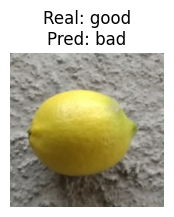

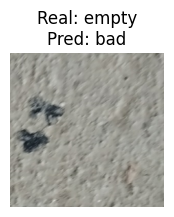

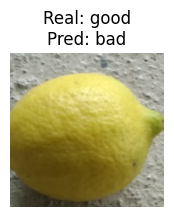

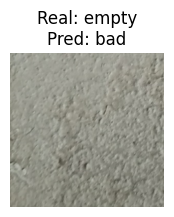

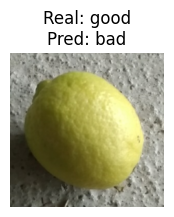

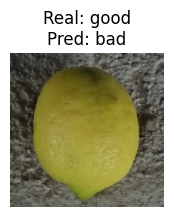

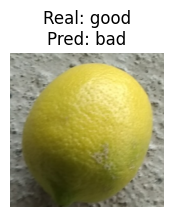

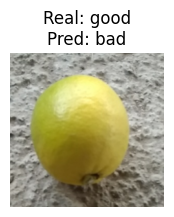

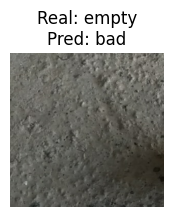

In [23]:
import matplotlib.pyplot as plt

def show_misclassified(model, dataset, class_names):
    for images, labels in dataset.take(1):
        preds = model.predict(images, verbose=0)
        y_true = tf.argmax(labels, axis=1)
        y_pred = tf.argmax(preds, axis=1)
        
        wrong = tf.where(y_true != y_pred).numpy().flatten()

        print(f"Total mal clasificadas en este batch: {len(wrong)}")
        for idx in wrong[:9]:  # mostrar máximo 9
            plt.figure(figsize=(2,2))
            plt.imshow(images[idx])
            plt.title(f"Real: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
            plt.axis("off")
            plt.show()

show_misclassified(model, trainer.test_ds, class_names)


## 6. Estrategia 2 (transfer learning)

Objetivo: probar ≥2 arquitecturas (p.ej., ResNet50 y MobileNetV2) con fine-tuning progresivo.

Evidencias: capas congeladas vs. descongeladas, LR schedule, métricas comparativas.

## 7. Monitorización y decisiones

Objetivo: early stopping, LR scheduler, selección de mejor checkpoint.

Evidencias: gráficos/metric logs y decisiones tomadas.


## 8. Evaluación final y comparación

Objetivo: métricas en test (accuracy, F1, matriz de confusión), comparación E1 vs E2.

Evidencias: tablas/resúmenes y conclusiones claras.

## 9. Conclusiones

Objetivo: discutir resultados, limitaciones y siguiente experimento sugerido.